Running Gradient Descent...
Gradient Descent: success, iterations: 26
Running Newton Method...
Newton Method: success, iterations: 2


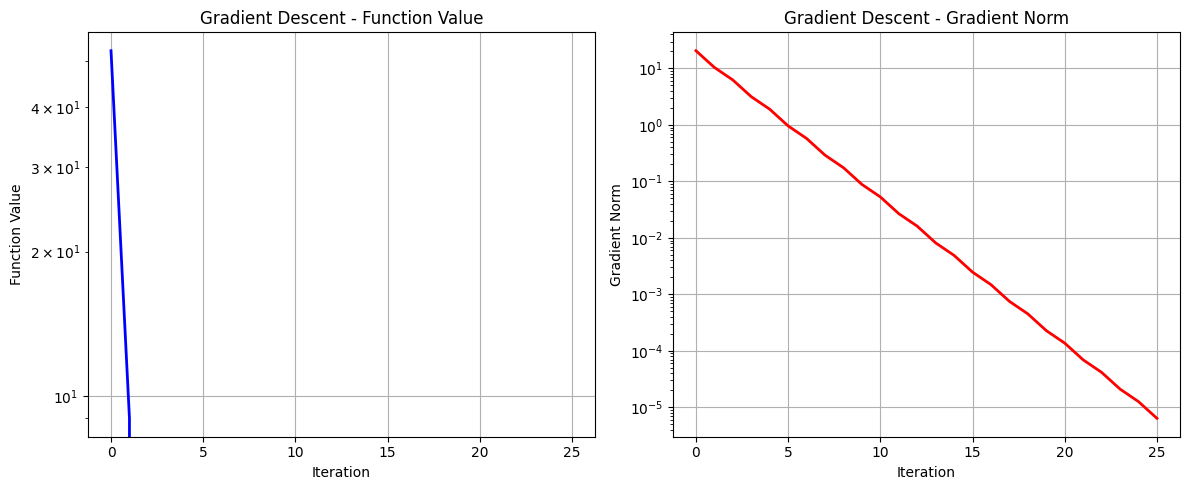

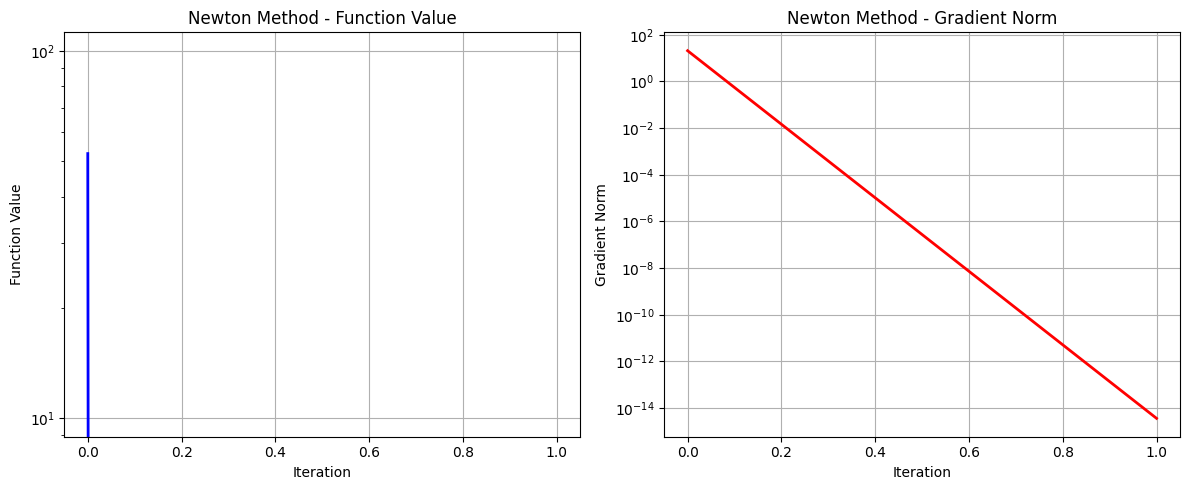

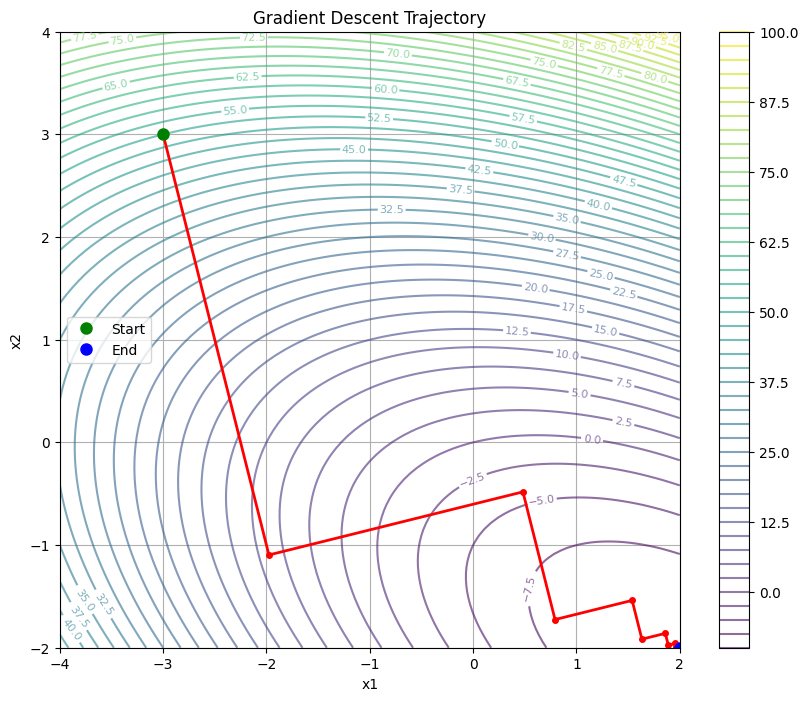

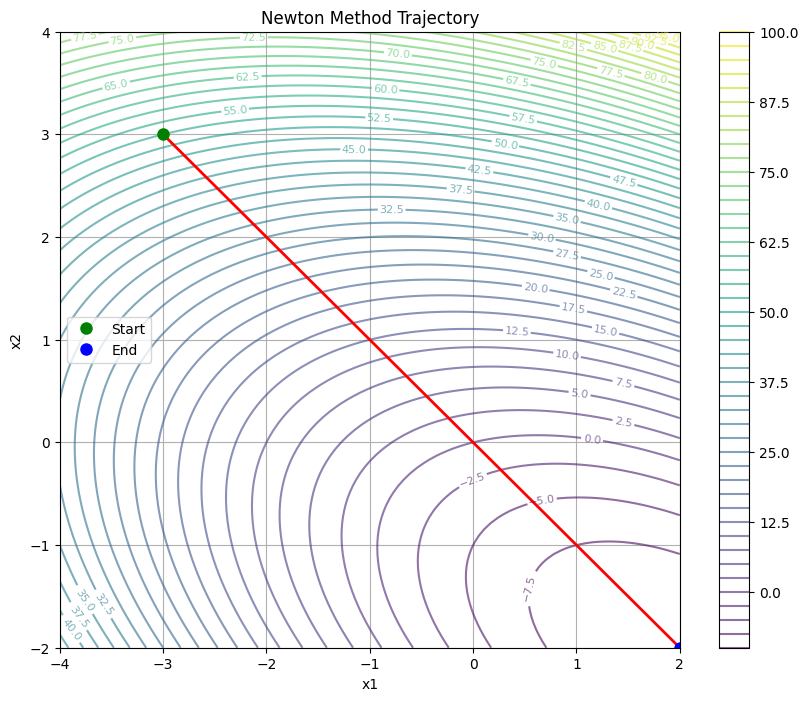

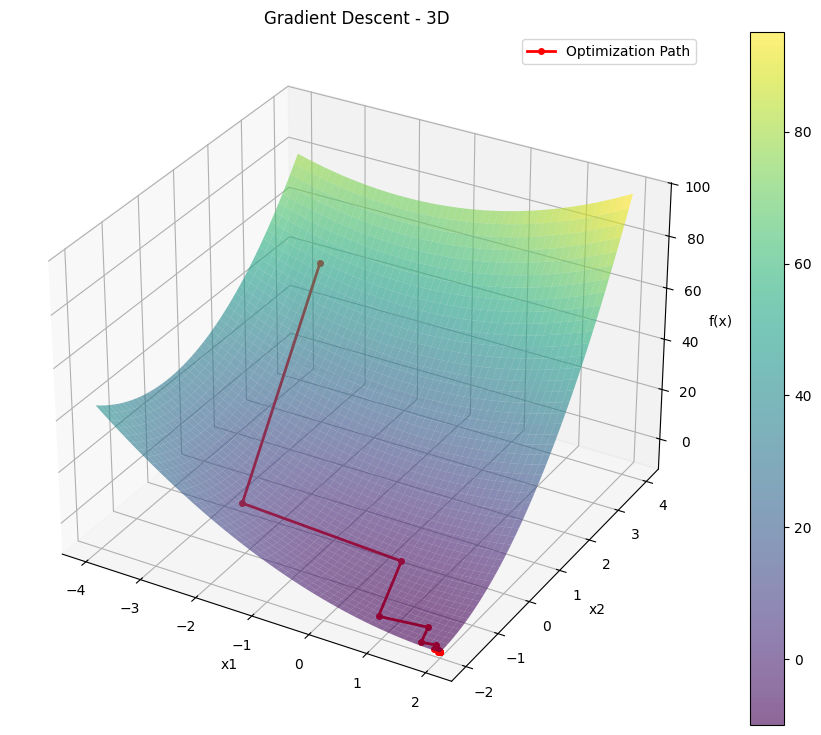

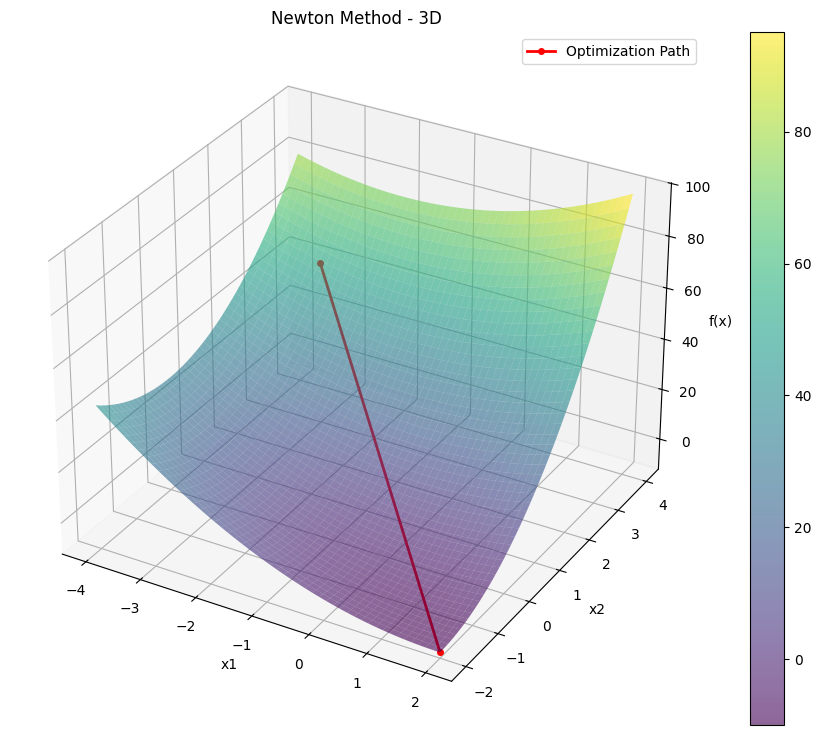

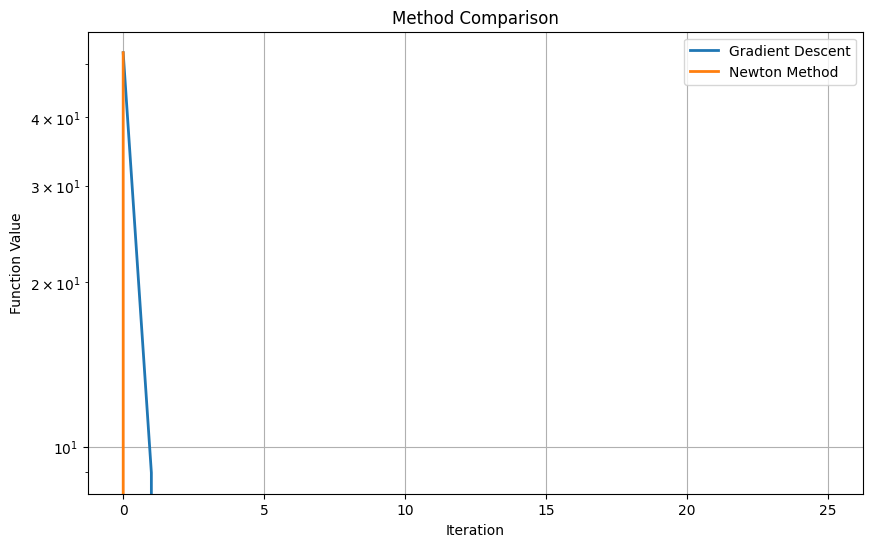

In [1]:
# optimization.py
import numpy as np
from scipy.optimize import line_search
import matplotlib.pyplot as plt
from matplotlib import cm
import plotly.graph_objects as go
import plotly.express as px

class LineSearchTool(object):
    """
    Класс для выбора шага в линейном поиске
    """
    def __init__(self, method='Wolfe', **kwargs):
        self.method = method
        self.c1 = kwargs.get('c1', 1e-4)
        self.c2 = kwargs.get('c2', 0.9)
        self.alpha_0 = kwargs.get('alpha_0', 1.0)

    def line_search(self, oracle, x, d):
        """
        Поиск шага alpha, удовлетворяющего условиям Вульфа или Армихо
        """
        phi = lambda a: oracle.func_directional(x, d, a)
        phi_grad = lambda a: oracle.grad_directional(x, d, a)

        phi_0 = phi(0)
        phi_grad_0 = phi_grad(0)

        if self.method == 'Constant':
            return self.alpha_0

        elif self.method == 'Wolfe':
            # Пробуем библиотечный метод Вульфа
            try:
                result = line_search(lambda x: oracle.func(x),
                                   lambda x: oracle.grad(x),
                                   x, d)
                if result[0] is not None:
                    return result[0]
            except:
                pass

            # Если метод Вульфа не сработал, используем бэктрекинг
            return self.backtracking(phi, phi_grad_0, phi_0)

        elif self.method == 'Armijo':
            return self.backtracking(phi, phi_grad_0, phi_0)

        else:
            raise ValueError("Unknown method")

    def backtracking(self, phi, phi_grad_0, phi_0):
        """
        Бэктрекинг с условием Армихо
        """
        alpha = self.alpha_0
        c1 = self.c1

        while phi(alpha) > phi_0 + c1 * alpha * phi_grad_0:
            alpha /= 2.0
            if alpha < 1e-10:  # Защита от слишком малых шагов
                break

        return alpha


def gradient_descent(oracle, x_0, tolerance=1e-5, max_iter=1000, line_search_options=None):
    """
    Градиентный спуск с линейным поиском
    """
    if line_search_options is None:
        line_search_options = {'method': 'Wolfe'}

    line_search_tool = LineSearchTool(**line_search_options)
    x = x_0.copy()
    history = []

    for k in range(max_iter):
        # Вычисляем градиент
        grad = oracle.grad(x)
        grad_norm = np.linalg.norm(grad)

        # Сохраняем историю
        history.append((x.copy(), oracle.func(x), grad_norm))

        # Критерий остановки
        if grad_norm < tolerance:
            return x, 'success', history

        # Направление спуска (антиградиент)
        d = -grad

        # Линейный поиск
        alpha = line_search_tool.line_search(oracle, x, d)

        # Обновление точки
        x = x + alpha * d

    return x, 'iterations_exceeded', history


def newton(oracle, x_0, tolerance=1e-5, max_iter=100, line_search_options=None):
    """
    Метод Ньютона с линейным поиском
    """
    if line_search_options is None:
        line_search_options = {'method': 'Wolfe'}

    line_search_tool = LineSearchTool(**line_search_options)
    x = x_0.copy()
    history = []

    for k in range(max_iter):
        # Вычисляем градиент и гессиан
        grad = oracle.grad(x)
        hess = oracle.hess(x)
        grad_norm = np.linalg.norm(grad)

        # Сохраняем историю
        history.append((x.copy(), oracle.func(x), grad_norm))

        # Критерий остановки
        if grad_norm < tolerance:
            return x, 'success', history

        # Решаем систему Hd = -g для направления Ньютона
        try:
            d = -np.linalg.solve(hess, grad)
        except np.linalg.LinAlgError:
            # Если гессиан вырожден, используем градиентный спуск
            d = -grad

        # Линейный поиск
        alpha = line_search_tool.line_search(oracle, x, d)

        # Обновление точки
        x = x + alpha * d

    return x, 'iterations_exceeded', history


def plot_optimization_history(history, title="Optimization History"):
    """
    Построение графиков истории оптимизации
    """
    iterations = list(range(len(history)))
    function_values = [h[1] for h in history]
    gradient_norms = [h[2] for h in history]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # График значений функции
    ax1.semilogy(iterations, function_values, 'b-', linewidth=2)
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Function Value')
    ax1.set_title(f'{title} - Function Value')
    ax1.grid(True)

    # График норм градиента
    ax2.semilogy(iterations, gradient_norms, 'r-', linewidth=2)
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Gradient Norm')
    ax2.set_title(f'{title} - Gradient Norm')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

    return fig


def plot_contour_trajectory(oracle, history, x_limits, y_limits, title="Optimization Trajectory"):
    """
    Построение траектории оптимизации на контурном графике (для 2D функций)
    """
    if len(history[0][0]) != 2:
        print("Contour plot is only available for 2D problems")
        return

    # Создаем сетку для контурного графика
    x1 = np.linspace(x_limits[0], x_limits[1], 100)
    x2 = np.linspace(y_limits[0], y_limits[1], 100)
    X1, X2 = np.meshgrid(x1, x2)

    # Вычисляем значения функции в узлах сетки
    Z = np.zeros_like(X1)
    for i in range(X1.shape[0]):
        for j in range(X1.shape[1]):
            Z[i, j] = oracle.func(np.array([X1[i, j], X2[i, j]]))

    # Извлекаем траекторию
    trajectory = np.array([h[0] for h in history])

    # Строим график
    plt.figure(figsize=(10, 8))

    # Контурный график
    contour = plt.contour(X1, X2, Z, levels=50, alpha=0.6)
    plt.clabel(contour, inline=True, fontsize=8)

    # Траектория оптимизации
    plt.plot(trajectory[:, 0], trajectory[:, 1], 'ro-', linewidth=2, markersize=4)
    plt.plot(trajectory[0, 0], trajectory[0, 1], 'go', markersize=8, label='Start')
    plt.plot(trajectory[-1, 0], trajectory[-1, 1], 'bo', markersize=8, label='End')

    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.colorbar(contour)
    plt.show()


def plot_3d_surface(oracle, history, x_limits, y_limits, title="3D Optimization Path"):
    """
    3D визуализация поверхности и траектории оптимизации
    """
    if len(history[0][0]) != 2:
        print("3D plot is only available for 2D problems")
        return

    # Создаем сетку
    x1 = np.linspace(x_limits[0], x_limits[1], 50)
    x2 = np.linspace(y_limits[0], y_limits[1], 50)
    X1, X2 = np.meshgrid(x1, x2)

    # Вычисляем значения функции
    Z = np.zeros_like(X1)
    for i in range(X1.shape[0]):
        for j in range(X1.shape[1]):
            Z[i, j] = oracle.func(np.array([X1[i, j], X2[i, j]]))

    # Траектория
    trajectory = np.array([h[0] for h in history])
    trajectory_z = [oracle.func(point) for point in trajectory]

    # 3D график
    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(111, projection='3d')

    # Поверхность
    surf = ax.plot_surface(X1, X2, Z, cmap=cm.viridis, alpha=0.6,
                          linewidth=0, antialiased=True)

    # Траектория
    ax.plot(trajectory[:, 0], trajectory[:, 1], trajectory_z,
           'r.-', linewidth=2, markersize=8, label='Optimization Path')

    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('f(x)')
    ax.set_title(title)
    plt.legend()
    plt.colorbar(surf)
    plt.show()


def compare_methods(oracles, methods, x_0, method_names, title="Method Comparison"):
    """
    Сравнение нескольких методов оптимизации
    """
    plt.figure(figsize=(10, 6))

    for i, (oracle, method) in enumerate(zip(oracles, methods)):
        # Запускаем оптимизацию
        if method.__name__ == 'gradient_descent':
            result, status, history = method(oracle, x_0)
        else:
            result, status, history = method(oracle, x_0)

        # Извлекаем значения функции
        function_values = [h[1] for h in history]

        # Строим график
        plt.semilogy(range(len(function_values)), function_values,
                    linewidth=2, label=method_names[i])

    plt.xlabel('Iteration')
    plt.ylabel('Function Value')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


# Пример использования:
if __name__ == "__main__":
    # Пример реализации oracle для тестирования
    class QuadraticOracle:
        def __init__(self, A, b):
            self.A = A
            self.b = b

        def func(self, x):
            return 0.5 * x.T @ self.A @ x - self.b.T @ x

        def grad(self, x):
            return self.A @ x - self.b

        def hess(self, x):
            return self.A

        def func_directional(self, x, d, alpha):
            return self.func(x + alpha * d)

        def grad_directional(self, x, d, alpha):
            return self.grad(x + alpha * d).T @ d

    # Тестовая задача
    A = np.array([[3, 2], [2, 6]])
    b = np.array([2, -8])
    oracle = QuadraticOracle(A, b)
    x_0 = np.array([-3, 3])

    # Запуск градиентного спуска
    print("Running Gradient Descent...")
    result_gd, status_gd, history_gd = gradient_descent(oracle, x_0)
    print(f"Gradient Descent: {status_gd}, iterations: {len(history_gd)}")

    # Запуск метода Ньютона
    print("Running Newton Method...")
    result_nt, status_nt, history_nt = newton(oracle, x_0)
    print(f"Newton Method: {status_nt}, iterations: {len(history_nt)}")

    # Построение графиков
    plot_optimization_history(history_gd, "Gradient Descent")
    plot_optimization_history(history_nt, "Newton Method")

    # Контурные графики
    plot_contour_trajectory(oracle, history_gd, [-4, 2], [-2, 4], "Gradient Descent Trajectory")
    plot_contour_trajectory(oracle, history_nt, [-4, 2], [-2, 4], "Newton Method Trajectory")

    # 3D графики
    plot_3d_surface(oracle, history_gd, [-4, 2], [-2, 4], "Gradient Descent - 3D")
    plot_3d_surface(oracle, history_nt, [-4, 2], [-2, 4], "Newton Method - 3D")

    # Сравнение методов
    compare_methods([oracle, oracle], [gradient_descent, newton], x_0,
                   ["Gradient Descent", "Newton Method"])